## Mask R-CNN 



Fine tuning a pre-trained Mask R-CNN với bộ dữ liệu   [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/)

Bộ dữ liệu gồm 170 hình ảnh với 345 người đi bộ đã được gắn nhãn

In [ ]:
%%shell

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-kqrr6fih
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-kqrr6fih
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266990 sha256=03e15ca20b3f9612cb8d3a742f2c6e12e0d534b41ead3d4ddf8e30d4d402fd69
  Stored in directory: /tmp/pip-ephem-wheel-cache-zrpkchhs/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1


In [ ]:
%%shell

# Download it for evaluation model
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 8556 (delta 11), reused 9 (delta 3), pack-reused 8526
Receiving objects: 100% (8556/8556), 10.34 MiB | 8.46 MiB/s, done.
Resolving deltas: 100% (5896/5896), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


### Chuẩn bị dữ liệu

In [ ]:
%%shell

# download the Penn-Fudan dataset and extract it
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

--2020-06-23 18:37:43--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  1009KB/s    in 48s     

2020-06-23 18:38:32 (1.06 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2020-06-23 18:38:32--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-06-23 18:38:32--
Total wall clock time: 49s
Downloaded: 1 files, 51M in 48s (1.06 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennF

Plot hình ảnh và mask của hình ảnh.

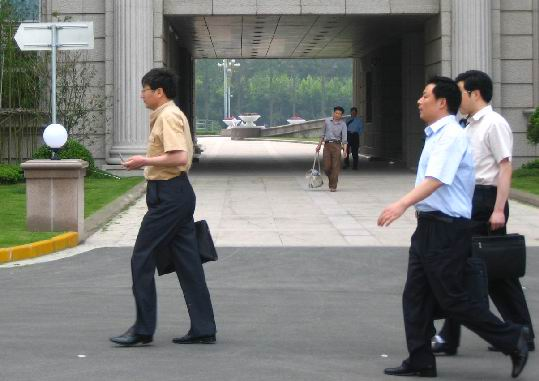

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00007.png')

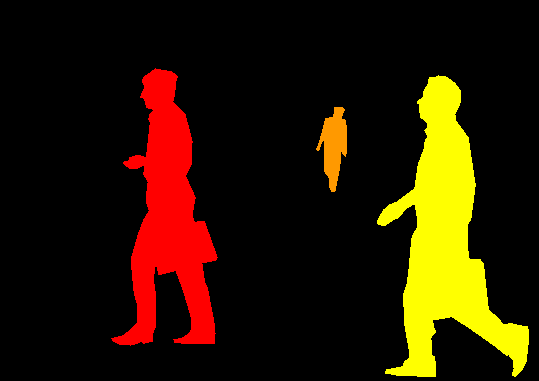

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00007_mask.png')

mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

Tạo class PennFudanDataset để đưa dữ liệu về dạng phù hợp với mô hình.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7F7933D52320>,
 {'area': tensor([35358., 36225.]), 'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]), 'image_id': tensor([0]), 'iscrowd': tensor([0, 0]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

Khởi tạo dataset (đưa dữ liệu về dạng phù hợp với mô hình) và dataloader để chuẩn bị cho việc train mô hình.

In [ ]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and test data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

### Train model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Sử dụng optimizer SGD với learning rate là 0.005, momentum là 0.9. Sau 3 epoch learning rate sẽ giảm đi 10 lần.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# dataset has two classes only - background and person
num_classes = 2


model = get_instance_segmentation_model(num_classes)
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)


lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


Train model với 10 epoch

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Epoch: [0]  [ 0/30]  eta: 0:00:57  lr: 0.000177  loss: 3.9831 (3.9831)  loss_classifier: 0.7697 (0.7697)  loss_box_reg: 0.1556 (0.1556)  loss_mask: 3.0330 (3.0330)  loss_objectness: 0.0140 (0.0140)  loss_rpn_box_reg: 0.0108 (0.0108)  time: 1.9324  data: 0.6633  max mem: 4791
Epoch: [0]  [10/30]  eta: 0:00:16  lr: 0.001900  loss: 1.8503 (1.9201)  loss_classifier: 0.4176 (0.4269)  loss_box_reg: 0.1689 (0.1836)  loss_mask: 1.0225 (1.2776)  loss_objectness: 0.0140 (0.0198)  loss_rpn_box_reg: 0.0108 (0.0123)  time: 0.8190  data: 0.0749  max mem: 5184
Epoch: [0]  [20/30]  eta: 0:00:07  lr: 0.003622  loss: 0.6928 (1.2977)  loss_classifier: 0.1895 (0.2878)  loss_box_reg: 0.1552 (0.1663)  loss_mask: 0.3326 (0.8126)  loss_objectness: 0.0137 (0.0175)  loss_rpn_box_reg: 0.0116 (0.0134)  time: 0.7246  data: 0.0166  max mem: 6667
Epoch: [0]  [29/30]  eta: 0:00:00  lr: 0.005000  loss: 0.4967 (1.0319)  loss_classifier: 0.0902 (0.2225)  loss_box_reg: 0.1415 (0.1529)  loss_mask: 0.2591 (0.6294)  loss_ob

### Test model

In [ ]:
img, _ = dataset_test[3]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


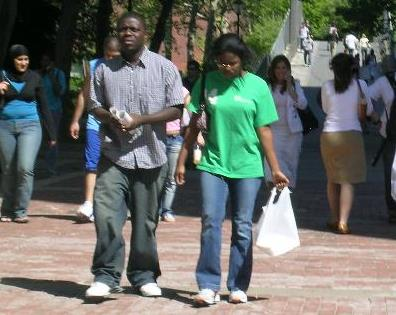

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
prediction

[{'boxes': tensor([[3.1955e+02, 5.2700e+01, 3.7476e+02, 2.3375e+02],
          [1.3506e-01, 4.6535e+01, 4.8826e+01, 2.2096e+02],
          [1.7930e+02, 3.7916e+01, 2.8208e+02, 3.0496e+02],
          [7.7171e+01, 1.9595e+01, 1.8297e+02, 2.9029e+02],
          [2.6344e+02, 5.8996e+01, 3.0999e+02, 2.2078e+02],
          [6.9586e+01, 3.5666e+01, 1.1954e+02, 2.3319e+02],
          [3.9874e+01, 5.6975e+01, 6.7833e+01, 1.6324e+02],
          [9.9360e+01, 9.8919e+01, 1.7322e+02, 2.9520e+02],
          [3.0019e+02, 2.0080e+01, 3.1328e+02, 6.4578e+01],
          [2.4955e+02, 3.1583e+01, 3.2355e+02, 2.6963e+02],
          [2.3272e+01, 4.8131e+01, 6.7902e+01, 2.0431e+02],
          [2.3186e+02, 5.5147e+01, 2.9660e+02, 2.9260e+02],
          [5.6857e+01, 6.1745e+00, 1.4059e+02, 2.7388e+02],
          [1.2133e+02, 5.7130e+01, 3.1342e+02, 2.9297e+02],
          [7.9516e+01, 1.0107e+02, 1.4616e+02, 2.9569e+02]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device

In [ ]:
prediction[0]['masks'].shape

torch.Size([15, 1, 315, 396])

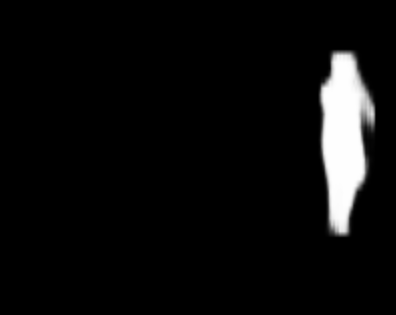

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

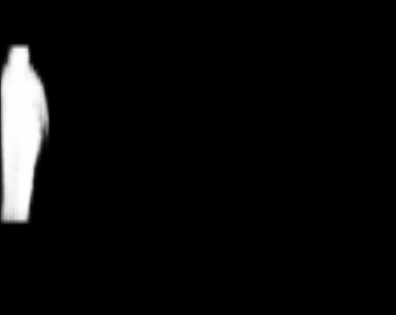

In [ ]:
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

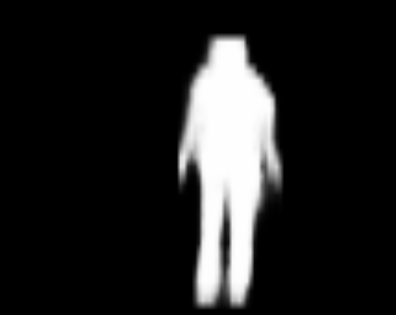

In [ ]:
Image.fromarray(prediction[0]['masks'][2, 0].mul(255).byte().cpu().numpy())

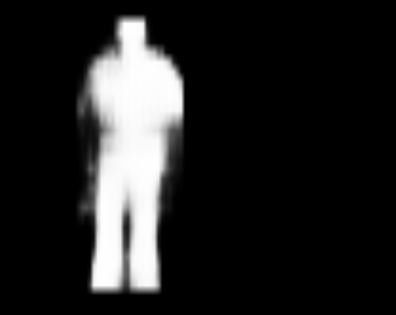

In [ ]:
Image.fromarray(prediction[0]['masks'][3, 0].mul(255).byte().cpu().numpy())

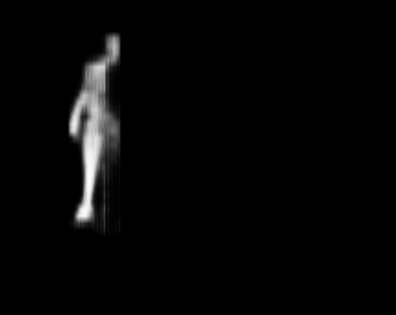

In [ ]:
Image.fromarray(prediction[0]['masks'][5, 0].mul(255).byte().cpu().numpy())